# Project description

We work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate.

Our job is to analyze clients' behavior and determine which prepaid plan brings in more revenue.

# Data description

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**The users table (data on users):**
- user_id — unique user identifier
- first_name — user's name
- last_name — user's last name
- age — user's age (years)
- city — user's city of residence
- reg_date — subscription date (dd, mm, yy)
- plan — calling plan name
- churn_date — the date the user stopped using the service (if the value is missing, the - calling plan was being used when this data was retrieved)

**The messages table (data on texts):**
- id — unique text message identifier
- user_id — the identifier of the user sending the text
- message_date — text message date

**The calls table (data on calls):**
- id — unique call identifier
- user_id — the identifier of the user making the call
- call_date — call date
- duration — call duration (in minutes)

**The internet table (data on web sessions):**
- id — unique session identifier
- user_id — user identifier
- session_date — web session date
- mb_used — the volume of data spent during the session (in megabytes)

**The plans table (data on the plans):**
- messages_included — monthly text allowance
- mb_per_month_included — data volume allowance (in megabytes)
- minutes_included — monthly minute allowance
- usd_monthly_pay — monthly charge in US dollars
- usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)
- usd_per_message — price per text after exceeding the package limits
- usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- plan_name — calling plan name

# Library imports

In [1]:
#Libraries and project environment setup:

##Pandas and numpy for data preprocessing and manipulation
import pandas as pd
import numpy as np

##Matplotlib for visualization
import matplotlib.pyplot as plt

##Remove warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore");

##Scipy for SDA
from scipy import stats as st

# CSV file read

In [2]:
#We use try-except to handle unexpected errors
try:
    df_users = pd.read_csv('/Users/EllaDS/Downloads/megaline_users.csv')
    df_calls = pd.read_csv('/Users/EllaDS/Downloads/megaline_calls.csv')
    df_messages = pd.read_csv('/Users/EllaDS/Downloads/megaline_messages.csv')
    df_internet = pd.read_csv('/Users/EllaDS/Downloads/megaline_internet.csv')
    df_plans = pd.read_csv('/Users/EllaDS/Downloads/megaline_plans.csv')
    
except:
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_users.csv')
    df_calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_calls.csv')
    df_messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_messages.csvmegaline_messages.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_internet.csv')
    df_plans = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_plans.csvmegaline_plans.csv')

# General information

## Users

In [3]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df_users.drop_duplicates(inplace=True,keep='first')
df_users.reset_index(drop=True, inplace=True)

In [4]:
#Print the first five entries in the dataframe
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


As stated in the data description, churn_date — the date the user stopped using the service (if the value is missing, the - calling plan was being used when this data was retrieved). That explains the NaN values in the column.

In [5]:
#General file examination
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


- Results show column names are accurate to the project data description.
- Dataset includes 500 entries and 8 columns.
- Only the churn_date contains missing values, 466 of them, to be exact.
- Both reg_date and churn_date contain object type values we'll need to convert to datetime.

In [6]:
#Integrated display of the columns
df_users.describe(include='all')

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
count,500.000000,500,500,500.000000,500,500,500,34
unique,NaN,458,399,NaN,73,266,2,29
top,NaN,Leonila,Grimes,NaN,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,surf,2018-12-18
freq,NaN,3,3,NaN,80,5,339,3
mean,1249.500000,NaN,NaN,45.486000,NaN,NaN,NaN,NaN
std,144.481833,NaN,NaN,16.972269,NaN,NaN,NaN,NaN
min,1000.000000,NaN,NaN,18.000000,NaN,NaN,NaN,NaN
25%,1124.750000,NaN,NaN,30.000000,NaN,NaN,NaN,NaN
50%,1249.500000,NaN,NaN,46.000000,NaN,NaN,NaN,NaN
75%,1374.250000,NaN,NaN,61.000000,NaN,NaN,NaN,NaN


- There are 500 users, 1 per entry.
- The min age is 18 (officially adult) and the max is 75, pretty reasonable.
- Most users are around ~45-46 years old.
- Outliers aren't currently apparent.

## Messages

In [7]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df_messages.drop_duplicates(inplace=True,keep='first')
df_messages.reset_index(drop=True, inplace=True)

In [8]:
#Print the first five entries in the dataframe
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [9]:
#General file examination
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
#We print id value counts to see the object type values to verify they aren't errors
df_messages.id.value_counts()

1343_431     1
1120_258     1
1435_188     1
1043_1014    1
1101_10      1
            ..
1380_314     1
1145_144     1
1061_52      1
1132_740     1
1057_82      1
Name: id, Length: 76051, dtype: int64

- Results show column names are accurate to the project data description.
- Dataset includes 76051 entries and 3 columns.
- There are no missing values.
- Message_date contains object type values we'll need to convert to datetime.
- ID contains object type values.

In [11]:
#Integrated display of the columns
df_messages.describe(include='all')

,id,user_id,message_date
count,76051,76051.000000,76051
unique,76051,NaN,351
top,1343_431,NaN,2018-12-28
freq,1,NaN,702
mean,NaN,1245.972768,NaN
std,NaN,139.843635,NaN
min,NaN,1000.000000,NaN
25%,NaN,1123.000000,NaN
50%,NaN,1251.000000,NaN
75%,NaN,1362.000000,NaN


There are 76051 IDs (messages), 1 per entry.

## Calls

In [12]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df_calls.drop_duplicates(inplace=True,keep='first')
df_calls.reset_index(drop=True, inplace=True)

In [13]:
#Print the first five entries in the dataframe
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [14]:
#General file examination
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 137735 entries and 4 columns.
- There are no missing values.
- Call_date contains object type values we'll need to convert to datetime.
- Duration contains float type values that will be changed to integer. Megaline rounds seconds up to minutes, each individual call is rounded up.

In [15]:
#Integrated display of the columns
df_calls.describe(include='all')

,id,user_id,call_date,duration
count,137735,137735.000000,137735,137735.000000
unique,137735,NaN,351,NaN
top,1398_16,NaN,2018-12-27,NaN
freq,1,NaN,1091,NaN
mean,NaN,1247.658046,NaN,6.745927
std,NaN,139.416268,NaN,5.839241
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1128.000000,NaN,1.290000
50%,NaN,1247.000000,NaN,5.980000
75%,NaN,1365.000000,NaN,10.690000


- There are 137735 IDs (calls), 1 per entry.
- Most calls (duration) are around ~6-7 minutes long.
- Mean and median values are almost the same, implying that the distribution doesn't have long tails. 
- Min duration (calls) is 0 minutes, maybe meaning a few seconds, so we'll round up these seconds to 1 minute. Max duration is ~37 minutes.

## Internet

In [16]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df_internet.drop_duplicates(inplace=True,keep='first')
df_internet.reset_index(drop=True, inplace=True)

In [17]:
#Print the first five entries in the dataframe
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [18]:
#General file examination
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


- Results show column names are accurate to the project data description.
- Dataset includes 104825 entries and 4 columns.
- There are no missing values.
- Session_date contains object type values we'll need to convert to datetime.
- Megaline rounds megabytes up to gigabytes, individual web sessions (mb_used) are not rounded up. Instead, the total for the month is rounded up.

In [19]:
#Integrated display of the columns
df_internet.describe(include='all')

,id,user_id,session_date,mb_used
count,104825,104825.000000,104825,104825.000000
unique,104825,NaN,351,NaN
top,1220_200,NaN,2018-12-24,NaN
freq,1,NaN,851,NaN
mean,NaN,1242.496361,NaN,366.713701
std,NaN,142.053913,NaN,277.170542
min,NaN,1000.000000,NaN,0.000000
25%,NaN,1122.000000,NaN,136.080000
50%,NaN,1236.000000,NaN,343.980000
75%,NaN,1367.000000,NaN,554.610000


- There are 104825 IDs (sessions), 1 per entry.
- Mean and median values are almost the same, implying that the distribution doesn't have long tails. 
- Most sessions (mb_used) spend around ~366 data volume.
- Min mb_used (sessions) is 0, Max is ~1693.

## Plans

In [20]:
#First, in order to guarantee efficiency we immediately drop row-based duplicates
df_plans.drop_duplicates(inplace=True,keep='first')
df_plans.reset_index(drop=True, inplace=True)

In [21]:
#Only 2 plans so we print the entire dataframe
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [22]:
#General file examination
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


- Results show column names are accurate to the project data description.
- Dataset includes 2 entries and 8 columns.
- There are no missing values.

In [23]:
#Integrated display of the columns
df_plans.describe(include='all')

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surf
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,NaN
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142,NaN
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000,NaN
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000,NaN
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,NaN
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000,NaN


There are 2 prepaid plans ('Surf' and 'Ultimate'). Errors aren't currently apparent.

# Preprocessing

## Data type conversion

### Datetime

In [24]:
#We covert dates from object type to datetime using a loop
for df in [df_users, df_messages, df_calls, df_internet]:
    for col in ['reg_date','churn_date','message_date','call_date','session_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

### Duration

In [25]:
#Rounding up call duration to minutes and changing type from float to integer
df_calls['duration'] = np.ceil((df_calls['duration'].values)).astype(int)

## Missing values

In [26]:
#Churn_date contains 466 missing values as calling plan was used while this data was generated
#We'll fill in this values with the word active
df_users['churn_date'] = df_users['churn_date'].fillna('active')

Duplicates have been taken care of above in the general information phase.

## Error detection

In [27]:
#Subscription date (reg_date) must be before or same as churn_date
df_users_dates=df_users.query('churn_date != "active"')
sum(df_users_dates['reg_date'] > df_users_dates['churn_date'])

0

Dates are in order.

In [28]:
#Message, call and session dates must also all be before or same as churn_date
#We'll create a merged dataframe and then verify the dates are in order
df_merged=df_users.merge(df_messages, how='left').merge(df_calls,how='left').merge(df_internet, how='left')
print(len(df_merged[df_merged['reg_date'] > df_merged['message_date']]),
     len(df_merged[df_merged['reg_date'] > df_merged['call_date']]),
     len(df_merged[df_merged['reg_date'] > df_merged['session_date']]))

0 0 0


Again, all dates are indeed in order.

## Calculations

### Number of calls made and minutes used per month

In [29]:
#Creating a month column
df_calls['month'] = df_calls['call_date'].dt.month
#Creating a pivot table
calls_per_month = df_calls.pivot_table(index=['user_id','month'],values=['duration'], aggfunc=['sum','count'])
calls_per_month.columns = ["mins_per_month","calls_per_month"]
#Resetting index
calls_per_month.reset_index(inplace=True)
#Printing
calls_per_month

,user_id,month,mins_per_month,calls_per_month
0,1000,12,124,16
1,1001,8,182,27
2,1001,9,315,49
3,1001,10,393,65
4,1001,11,426,64
...,...,...,...,...
2253,1498,12,339,39
2254,1499,9,346,41
2255,1499,10,385,53
2256,1499,11,308,45


### Number of text messages sent per month

In [30]:
#Creating a month column
df_messages['month'] = df_messages['message_date'].dt.month
#Creating a pivot table
messages_per_month = df_messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count')
messages_per_month.columns = ["messages_per_month"]
#Resetting index
messages_per_month.reset_index(inplace=True)
#Printing
messages_per_month

,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


### Volume of data per month

In [31]:
#Creating a month column
df_internet['month'] = df_internet['session_date'].dt.month
#Creating a pivot table
volume_per_month = df_internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum')
volume_per_month.columns = ["mb_per_month"]
#Adding gb_per_month column as Megaline total monthly megabytes to gigabytes
volume_per_month['gb_per_month'] = np.ceil((volume_per_month['mb_per_month'].values) / 1024).astype(int)
#Resetting index
volume_per_month.reset_index(inplace=True)
#Printing
volume_per_month

,user_id,month,mb_per_month,gb_per_month
0,1000,12,1901.47,2
1,1001,8,6919.15,7
2,1001,9,13314.82,14
3,1001,10,22330.49,22
4,1001,11,18504.30,19
...,...,...,...,...
2272,1498,12,23137.69,23
2273,1499,9,12984.76,13
2274,1499,10,19492.43,20
2275,1499,11,16813.83,17


### Monthly revenue from each user

In [32]:
#Merging all monthly dataframes we calclutaed above with df_users and df_plans
plan_per_user = df_users[['user_id','plan', 'city']].merge(df_plans, left_on='plan', right_on='plan_name')
monthly = (calls_per_month.merge(messages_per_month, how='outer', on=['user_id','month'])
              .merge(volume_per_month, how='outer', on=['user_id','month'])
              .merge(plan_per_user, on='user_id'))
#Resetting index
monthly.reset_index(inplace=True)
#Printing first 5 entries 
monthly.head()

,index,user_id,month,mins_per_month,calls_per_month,messages_per_month,mb_per_month,gb_per_month,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,0,1000,12,124.0,16.0,11.0,1901.47,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,ultimate
1,1,1001,8,182.0,27.0,30.0,6919.15,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,surf
2,2,1001,9,315.0,49.0,44.0,13314.82,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,surf
3,3,1001,10,393.0,65.0,53.0,22330.49,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,surf
4,4,1001,11,426.0,64.0,36.0,18504.30,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,surf


In [33]:
#Checking for missing values
monthly.isna().sum()*100/len(monthly)

index                     0.000000
user_id                   0.000000
month                     0.000000
mins_per_month            1.526385
calls_per_month           1.526385
messages_per_month       21.238552
mb_per_month              0.697776
gb_per_month              0.697776
plan                      0.000000
city                      0.000000
messages_included         0.000000
mb_per_month_included     0.000000
minutes_included          0.000000
usd_monthly_pay           0.000000
usd_per_gb                0.000000
usd_per_message           0.000000
usd_per_minute            0.000000
plan_name                 0.000000
dtype: float64

In [34]:
#These missing values are of number calls (and minutes), messages and volume used. 
#Most likely since these services haven't been used, therefore we'll fill them in with 0, using a loop.
for col in ['mins_per_month','calls_per_month','messages_per_month','mb_per_month','gb_per_month']:
    monthly[col] = monthly[col].fillna(0)
monthly.isna().sum()*100/len(monthly)

index                    0.0
user_id                  0.0
month                    0.0
mins_per_month           0.0
calls_per_month          0.0
messages_per_month       0.0
mb_per_month             0.0
gb_per_month             0.0
plan                     0.0
city                     0.0
messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
usd_monthly_pay          0.0
usd_per_gb               0.0
usd_per_message          0.0
usd_per_minute           0.0
plan_name                0.0
dtype: float64

Much better, now we move on to calculating the monthly revenue generated by each user by subtracting the free package limit from the total number of calls, text messages, and data. Then, multiplying the result by the calling plan value.
And finally, adding the monthly charge depending on the calling plan.

In [35]:
call_cost=monthly.apply(lambda x: max(0,x['mins_per_month']-x['minutes_included'])*x['usd_per_minute'],axis=1)
message_cost=monthly.apply(lambda x: max(0, x['messages_per_month'] - x['messages_included']) * x['usd_per_message'],axis = 1)
gb_cost=monthly.apply(lambda x: np.ceil(max(0, x['mb_per_month'] - x['mb_per_month_included'])/1024)*x['usd_per_gb'],axis = 1)
monthly['monthly_revenue']=call_cost+message_cost+gb_cost+monthly['usd_monthly_pay']

In [36]:
monthly[['user_id','month','monthly_revenue']]

,user_id,month,monthly_revenue
0,1000,12,70.00
1,1001,8,20.00
2,1001,9,20.00
3,1001,10,90.09
4,1001,11,60.00
...,...,...,...
2288,1204,12,112.00
2289,1349,10,20.78
2290,1349,11,40.66
2291,1349,12,20.33


# EDA - distribution

Here we'll describe the customers' behavior. To so so we'll find the minutes, texts, and volume of data the users of each plan require per month by plotting histograms. Then, calculate the mean, variance, and standard deviation. And finally, describe the distributions.

In [37]:
#In order to analyze monthly user behaviour of each plan, we create 2 dataframes one per plan
df_surf=monthly[monthly['plan'] == 'surf']
df_ultimate=monthly[monthly['plan'] == 'ultimate']

## Minutes

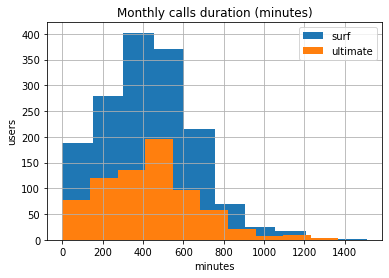

In [38]:
#Minutes the users of 'Surf' and 'Ultimate' use per month
monthly.groupby(by='plan')['mins_per_month'].plot(kind='hist', grid=True)
plt.title('Monthly calls duration (minutes)')
plt.xlabel('minutes')
plt.ylabel('users')
plt.legend(loc='upper right');

In [39]:
#'Surf' mean, variance, and standard deviation
print('Mean of "Surf" monthly calls duration in minutes: {:.0f}'.format(df_surf['mins_per_month'].mean()))
print('Variance of "Surf" monthly calls duration in minutes: {:.0f}'.format(df_surf['mins_per_month'].var()))
print('Standard deviation of "Surf" monthly calls duration in minutes: {:.0f}'.format(df_surf['mins_per_month'].std()))
print()
#'Ultimate' mean, variance, and standard deviation
print('Mean of "Ultimate" monthly calls duration in minutes: {:.0f}'.format(df_ultimate['mins_per_month'].mean()))
print('Variance of "Ultimate" monthly calls duration in minutes: {:.0f}'.format(df_ultimate['mins_per_month'].var()))
print('Standard deviation of "Ultimate" monthly calls duration in minutes: {:.0f}'.format(df_ultimate['mins_per_month'].std()))

Mean of "Surf" monthly calls duration in minutes: 429
Variance of "Surf" monthly calls duration in minutes: 54968
Standard deviation of "Surf" monthly calls duration in minutes: 234

Mean of "Ultimate" monthly calls duration in minutes: 430
Variance of "Ultimate" monthly calls duration in minutes: 57844
Standard deviation of "Ultimate" monthly calls duration in minutes: 241


In [40]:
print(df_surf.shape, df_ultimate.shape)

(1573, 19) (720, 19)


Means of monthly call durations are almost the same (Surf-429 and Ultimate-430), implying that the distribution is close to normal. Both plans histograms are positively skewed to the right. Standard deviations are also quite close (Surf-234 and Ultimate-241 minutes each) and the variance is large as the data is more spread out.

Surf has 1573 users and Ultimate has 720 as seen in the histogram where surf user values are higher. Most users' calls last anywhere from 250 to just over 400 minutes.

We see almost half of the Surf plan users exceed the limit (500 minutes per month) while none of Ulimate's come anywhere close to their limit of 3000 (~1500 at most-half the limit), meaning the Ultimate plan isn't profitable in the least in this case.

## Texts

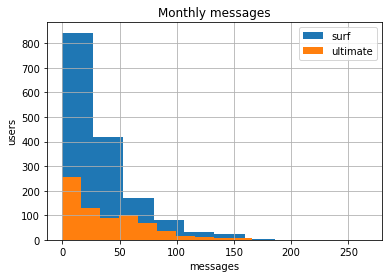

In [41]:
#Texts the users of 'Surf' and 'Ultimate' send per month
monthly.groupby(by='plan')['messages_per_month'].plot(kind='hist', grid=True)
plt.title('Monthly messages')
plt.xlabel('messages')
plt.ylabel('users')
plt.legend(loc='upper right');

In [42]:
#'Surf' mean, variance, and standard deviation
print('Mean of "Surf" monthly messages: {:.0f}'.format(df_surf['messages_per_month'].mean()))
print('Variance of "Surf" monthly messages: {:.0f}'.format(df_surf['messages_per_month'].var()))
print('Standard deviation of "Surf" monthly messages: {:.0f}'.format(df_surf['messages_per_month'].std()))
print()
#'Ultimate' mean, variance, and standard deviation
print('Mean of "Ultimate" monthly messages: {:.0f}'.format(df_ultimate['messages_per_month'].mean()))
print('Variance of "Ultimate" monthly messages: {:.0f}'.format(df_ultimate['messages_per_month'].var()))
print('Standard deviation of "Ultimate" monthly messages: {:.0f}'.format(df_ultimate['messages_per_month'].std()))

Mean of "Surf" monthly messages: 31
Variance of "Surf" monthly messages: 1127
Standard deviation of "Surf" monthly messages: 34

Mean of "Ultimate" monthly messages: 38
Variance of "Ultimate" monthly messages: 1209
Standard deviation of "Ultimate" monthly messages: 35


Means of monthly messages and standard deviations are close- std is almost same as the mean (Surf-mean 31, std 34 and Ultimate-mean 38, std 35). Both plans histograms are positively skewed to the right, and not too spread out.

Surf has 1573 users and Ultimate has 720 as seen in the histogram where surf user values are higher. Most users send a number of monthly messages anywhere from 0 to just over ~25. 

We see most Surf plan users stay in the limit (500 messages per month) and none of Ulimate's come anywhere close to their limit of 1000 (~250 at most-quater the limit), meaning the Ultimate plan isn't profitable in the least in this case.

## Volume

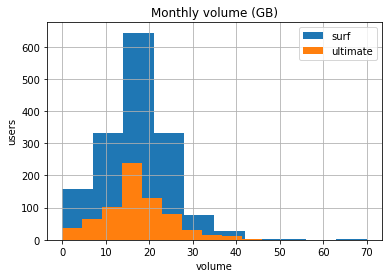

In [43]:
#Volume of data the users of 'Surf' and 'Ultimate' require per month
monthly.groupby(by='plan')['gb_per_month'].plot(kind='hist', grid=True)
plt.title('Monthly volume (GB)')
plt.xlabel('volume')
plt.ylabel('users')
plt.legend(loc='upper right');

In [44]:
#'Surf' mean, variance, and standard deviation
print('Mean of "Surf" monthly volume: {:.0f}'.format(df_surf['gb_per_month'].mean()))
print('Variance of "Surf" monthly volume: {:.0f}'.format(df_surf['gb_per_month'].var()))
print('Standard deviation of "Surf" monthly volume: {:.0f}'.format(df_surf['gb_per_month'].std()))
print()
#'Ultimate' mean, variance, and standard deviation
print('Mean of "Ultimate" monthly volume: {:.0f}'.format(df_ultimate['gb_per_month'].mean()))
print('Variance of "Ultimate" monthly volume: {:.0f}'.format(df_ultimate['gb_per_month'].var()))
print('Standard deviation of "Ultimate" monthly volume: {:.0f}'.format(df_ultimate['gb_per_month'].std()))

Mean of "Surf" monthly volume: 17
Variance of "Surf" monthly volume: 62
Standard deviation of "Surf" monthly volume: 8

Mean of "Ultimate" monthly volume: 17
Variance of "Ultimate" monthly volume: 59
Standard deviation of "Ultimate" monthly volume: 8


Means of monthly volume are almost the same (Surf-17 gb per month and Ultimate-18), both distributions are similar and close to normal. Standard deviations are the same and not that large (both 8 gb) and the variance is close (Surf-64, Ultimate-62.

Surf has 1573 users and Ultimate has 720 as seen in the histogram where surf user values are higher. Most users' volume usage is anywhere from 0 to just over 70 gigabytes.

We see almost half of the Surf plan users don't exceed the limit (16 gb per month- close to the mean usage) while only very few of Ulimate's exceed their limit of 31. This is the most profitable service for both plans yet still way less for Ultimate out of the two.

# SDA - hypotheses testing

## Average revenue from users of Ultimate and Surf calling plans differs

Null Hypothesis H0: average revenue from users of Ultimate and Surf calling plans doesn't differ.

Alternative Hypothesis H1: average revenue from users of Ultimate and Surf calling plans differs.

The criterion we'll use to test the hypotheses is 5% significance level (alpha) as it is typical in behavioral science.

In [45]:
#Testing hypotheses by running t-test
results = st.ttest_ind(df_surf['monthly_revenue'], df_ultimate['monthly_revenue'], equal_var=False)
p_value = results.pvalue
alpha = 0.05

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  3.17039054811355e-15
We reject the null hypothesis


T-test results above show that based on the p_value, we reject the null hypothesis. Therefore, the average revenue from users of Ultimate and Surf calling plans differs.

Note: We choose not to further analyze the hypotheses to test what plan has the higher average monthly revenue, since we already gathered above in the EDA phase that Surf is more profitable.

## Average revenue from users in NY-NJ area is different from that of the users from other regions

Null Hypothesis H0: average revenue from users in NY-NJ area isn't different from that of the users from other regions.

Alternative Hypothesis H1: average revenue from users in NY-NJ area is different from that of the users from other regions.

Once again, the criterion we'll use to test the hypotheses is 5% significance level (alpha) as it is typical in behavioral science.

In [46]:
#We create 2 dataframes for NY-NJ area and others and then 2 more of revenue per area
NY_NJ=monthly[monthly['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
NY_NJ_revenue=NY_NJ['monthly_revenue']
other=monthly[monthly['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']
other_revenue=other['monthly_revenue']

In [47]:
#Again, we test hypotheses by running t-test
results = st.ttest_ind(NY_NJ_revenue, other_revenue, equal_var=False)
p_value = results.pvalue
alpha = 0.05

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.03352561588530014
We reject the null hypothesis


T-test results above show that based on the p_value, we reject the null hypothesis. Therefore, the average revenue from users in NY-NJ area is different from that of the users from other regions.

Note: We choose not to further analyze the hypotheses to test what area has the higher average monthly revenue, since we need to determine which prepaid plan brings in more revenue and not which area does.

# Overall conclusion

In this project, we have worked as analysts for the telecom operator Megaline, which offers its clients two prepaid plans, Surf and Ultimate. 

The commercial department wanted to know which of the plans generates more revenue in order to adjust the advertising budget.

First, following the methodology, we performed a preliminary analysis of the plans based on the data of 500 Megaline users: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. 
We analyzed clients' behavior and finally determined which prepaid plan brings in more revenue.

In conclusion, the data analysis revealed that the Surf plan generates more revenue than Ultimate.

Surf plan has lower package limits in comparison to Ultimate as 50% less GB; 95% less texts; and 16.66% less calls. Hence, users exceed the Surf plan limits and end up generating higher revenue. Unlike Surf, Ultimate plan offers high package limits and therefore users don't reach them and all in the all the plan is not profitable to Megaline and even loss-making. 